<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 1 - Importer les données et explorer les radiographies</span>

Dans ce notebook nous allons traiter les parties 1 a 3 du projet

<span style="color:blue;font-size:1.2em;font-weight:bold">Mise en place</span>

In [1]:
# Module pour recharger un module sans redemarrer le kernel
# import importlib
%load_ext autoreload
%autoreload 2

In [ ]:
# imports
import numpy as np
import pandas as pd
from pathlib import Path
import gc
import matplotlib.pyplot as plt
from PIL import Image

# On utilise pytorch ici plutot que tensorflow
# Avantage: plus personnalisable VS Plus facile a utiliser 
# Définit les tenseurs, couches de neurones et algo d'opti (SGD,Adam)
import torch
# Pour créer une structure pour lire les images et les envoyer par paquet (batches) au GPU
from torch.utils.data import DataLoader



In [3]:
# Sert à éviter les Warnings avec les transformations sur des vues en transformant 
# ces warning en erreur obligeant ainsi à ne travailler que sur des copies ou les originaux.

pd.set_option('mode.chained_assignment','raise')

In [4]:
# Ajoute le dossier datas_manipulation au sys.path. Remarque ne pas oublier le __init__.py dans le dossier datas_manipulation
import sys
# root_path = Path(__file__).resolve().parents[1] # Ne fonctionne pas sur notebook
ROOT_PATH = Path.cwd().parent
sys.path.append(str(ROOT_PATH))

In [ ]:
# Fonctions personnelles

from notebooks.utils.dataset import BaseTransform, ImagesToDataset
from notebooks.utils.models import FeatureExtractor
from notebooks.utils.analysis import ClusterManager
from notebooks.utils.training import SslManager
from notebooks.utils.plotting.make_model_plots import plot_clustering
from notebooks.utils.data_manipulation import save_datas
from notebooks.utils.plotting.config_figures import save_figure


In [6]:
# Variables/paramètres globales

# Création dossier results
SAVE_PATH = ROOT_PATH.joinpath('datas/results')
Path.mkdir(SAVE_PATH,exist_ok = True)

# Pour la reproductibilité (similaire a random_state) 
# --> influence l'initialisation des poids ResNet et le mélange du DataLoader
torch.manual_seed(42)
np.random.seed(42)

# Config pour basculer sur le GPU si possible (50x plus rapide en deep learning que CPU)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")
# Taille des paquets (en puissance de 2 pour s'aligner avec l'archi GPU: 2 4 8 16 32 64)
BATCH_SIZE = 16

# Config des images
IMG_SIZE = 224 # Résolution standard 
# Cas transfer learning avec ResNet: Les valeurs données sont les moyennes et ecarts type des 
# couleurs RGB dans ImageNet
IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

RANDOM_STATE=42
N_JOBS=-1
# N_FEATURES = 512 # Nombre de features issu des CNN,en 18,34 couches on a 512 features, 
# # en 50,101 et 152 on passe a 2048 features, avec VGG16 on est 4096 
# # et pour EfficientNet-BO c'est 1280 features
TEST_SIZE = 0.2
N_EPOCH = 10
EXPERIMENT_NAME = "experiment_01"

Running on: cpu


In [7]:
# Dictionnaire de la confinguration globale du projet
project_config = {
    "model":"resnet18",
    # "n_features":N_FEATURES,
    "n_jobs":N_JOBS,
    "batch":BATCH_SIZE,
    "device":str(DEVICE),
    "img_size":IMG_SIZE,
    "img_mean":IMG_MEAN,
    "img_std":IMG_STD,
    "test_size":TEST_SIZE,
    "random_state":RANDOM_STATE,
}

In [8]:
# Chemin des données brutes
DATAS_PATH = ROOT_PATH/"datas/raw/mri_dataset_brain_cancer_oc"

# Listing des fichiers qui composent les labellisés des non labellisés
# glob pour les fichiers et rglob si il y a des sous-dossiers
avec_labels_path = list((DATAS_PATH / "avec_labels").rglob("*.jpg"))
sans_label_path = list((DATAS_PATH / "sans_label").glob("*.jpg"))
project_config.update({"avec_label":len(avec_labels_path),"sans_label":len(sans_label_path)})

# Encodage des labels (0: normal, 1: cancer, -1: sans_label)
avec_labels_encoding = [1 if "cancer" in path.parts else 0 for path in avec_labels_path]
all_paths = avec_labels_path + sans_label_path
all_labels = avec_labels_encoding + ([-1] * len(sans_label_path))


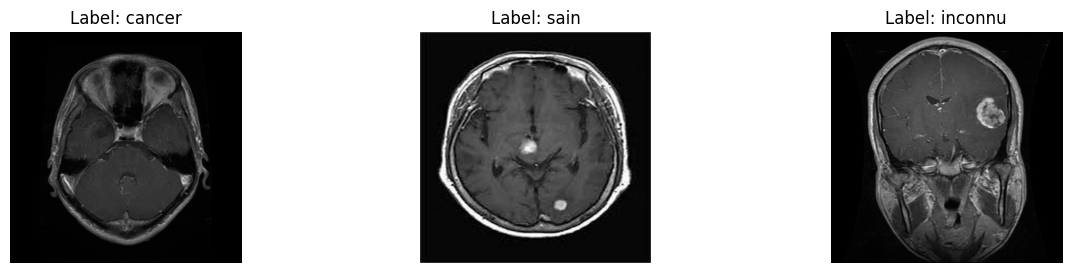

In [9]:
# Visualisation de quelques exemples
path_samples = [avec_labels_path[0], avec_labels_path[50], sans_label_path[0]]
label_samples = ["cancer","sain","inconnu"]

fig, axes = plt.subplots(1, len(path_samples), figsize=(15, 3))
for i,(path,label) in enumerate(zip(path_samples,label_samples)):
    image = Image.open(path)
    # L'image est un tensor, on le convertit en numpy array et on le transpose pour l'affichage
    # On dénormalise aussi l'image pour un affichage correct
    # img = image.numpy().transpose(1, 2, 0) * 0.5 + 0.5
    # axes[i].imshow(img.squeeze(), cmap='gray') # Use cmap='gray' for single channel images if needed
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()

In [10]:
print("=============== Contenu du dataset ================")
with open(
    DATAS_PATH/"Jeu de Données d'Images Cérébrales pour la Détection de Tumeurs.txt",
    "r",
    encoding="utf-8"
) as f:
    print(f.read())

=============== Contenu du dataset ================
Description

Ce jeu de données comprend un total de 1500 images :

    1400 images non étiquetées

    100 images étiquetées

Les images étiquetées sont réparties en deux catégories :

    Normal : Images de cerveaux sains.

    Cancer : Images de cerveaux présentant des signes de tumeurs.

Caractéristiques des Images

Toutes les images ont été redimensionnées à une taille standardisée de 512×512 pixels. Cette standardisation assure leur compatibilité avec divers pipelines de traitement d'images et d'apprentissage automatique. Elles sont enregistrées au format d'image courant JPEG (.jpg).
Applications Potentielles

Ce jeu de données peut être exploité pour un large éventail d'applications, notamment :

    🤖 L'entraînement et l'évaluation de divers modèles d'apprentissage profond (par exemple, DenseNet201, YOLOv8x/s, CNN, ResNet50v2, VGG-16, MobileNetV2).

    🔬 Le développement d'algorithmes de classification d'images pour la détecti

Le zip "**mri_dataset_brain_cancer_oc**" contient deux dossiers et un fichier texte qui résume le contenu du dataset:
- **sans_label/**: 1406 images non étiquetées
- **avec_labels/**: 100 images étiquetées

Dans le dossier avec label on trouve deux sous-dossiers:
- **Normal/** : 50 images de cerveaux sains.
- **Cancer/** : 50 images de cerveaux présentant des signes de tumeurs.

**Caractéristiques des images**

- Toutes les images ont été redimensionnées à une taille standardisée de 512×512 pixels. 
- Elles sont enregistrées au format d'image courant JPEG (.jpg).
- Poids moyen autour de 20 Ko
- Nomination hashé
- Noir et blanc
- Qualité des images variable (floue, saturée ...)
- Coupes variables (dessus, de face, de profil) avec prédominance des coupes du dessus (ou dessous?)
- Certaines images ont des cadres, des echelles, des caractéristiques d'imagerie (W,L, n°)

<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 2 - Pré-traitement et extraction des features</span>

Comme nous l'avions relevé, les images nécéssitent un pré traitement afin de pouvoir être utilisable. Elles ont la même structure externe (pixels, format, poids, nomination) mais leur contenu doit aussi être standardiser:
- normaliser la nuance de gris
- enlever les informations d'image dans les images (W,L,n°) ($\approx$ data leaking)
Une fois celà fait, il restera à transformer les images en données exploitable à savoir l'embedding visuel via ResNet.

<span style="color:blue;font-size:1.2em;font-weight:bold">Préparation et embedding</span>

<span style="color:orange;font-weight:bold"> *Remarque personnelle*: Il est interessant de s'appercevoir que Pytorch pousse à travailler au travers de subclass. De plus, au fil du projet, on prend conscience de la nécessité du GPU pour le traitement d'image. En effet, traiter une image revient globalement a appliquer des opérations basiques sur un empilement (couleur RGB, RGBA,...) de matrice 2D massifs (hauteur, largeur): on arrive sur des tenseurs ND. On est donc sur des tâches simples massivement parallélisables, exactement ce qu'un GPU peut faire sans problème aujourd'hui contrairement au CPU.</span>

In [11]:
del (
    #avec_labels_path, sans_label_path, avec_labels_encoding, # Réutilisés dans en supervisé
    path_samples,label_samples,image,fig,axes
)
gc.collect()

6594

<span style="color:purple;font-weight:bold">Extraction des features via ResNet</span>

Comme toujours, il est nécéssaire d'avoir des informations compréhensibles pour une machine pour qu'un modèle puisse performer (ce n'est donc pas le cas des images). Pour cela on va donc pré-traiter les images afin qu'elles partent d'une base commune (redimensionnement et normalisation).

On va ensuite utiliser un CNN (ResNet18 par exemple) auquel on retire la dernière couche (couche de classification) afin d'obtenir un extracteur de features et on fait passer toutes les images pour constituer un tableau dont les lignes représentent les images et les colonnes, les caractéristiques de ces images.

In [12]:
# Traitement des images
# Instanciation du pré traitement
transform = BaseTransform(mean=IMG_MEAN,std=IMG_STD,size=IMG_SIZE).preproc(train=False)
# Génration du dataset SANS les augmentations (train et test encore mélangé pour le moment)
full_dataset = ImagesToDataset(all_paths, all_labels, transform=transform)
# Génération du loader qui va fournir la donnée au GPU par batch
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Instanciation du modèle d'extraction des caractéristiques
# to(DEVICE) déplace les poids du modèle de la RAM/CPU vers la VRAM/GPU
extractor = FeatureExtractor(pretrained=True,model_name=project_config['model']).to(DEVICE)
project_config.update({"n_features":extractor.n_features})
# Rend le comportement de certaines couches déterministes ==> indispensable pour l'embedding
extractor.eval()

# Extraction
features_list = []
labels_list = []
paths_list = []

# Par défaut, Pytorch mémorise chaque calcul pour faire la retropropagation de gradient
# indispensable si entrainement or ici on souhaite juste lire, on desactive donc la mémoire.
with torch.no_grad():
    for images, labels, path in full_loader:
        images = images.to(DEVICE)
        features = extractor(images) # (Batch, N_FEATURES)
        features_list.extend(features.cpu().numpy()) # GPU --> CPU + tenseurs --> tableau numpy
        labels_list.extend(labels.cpu().tolist())
        paths_list.extend(path)

# Mise sous forme de df
cols = [f"feature_{i}" for i in range(extractor.n_features)]
df_features = pd.DataFrame(features_list, columns=cols)
# Ajout des colonnes de labellisation et de chemin d'image
df_features['label'] = labels_list
df_features['path'] = paths_list

In [13]:
# ================= Nettoyage et sauvegarde ========================
del full_dataset, full_loader, images, features, features_list, labels_list, cols, paths_list
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

**Remarque**: Le gèle des couches convolutionnelles s'est faite en utilisant .eval() et .no_grad().
- model.eval() agit sur certaines couches comme le batch normalization ou le dropout qui a un comportement aléatoire afin de les rendre déterministe. Au contraire, on souhaite les activer en entrainement afin que le modèle ne puisse pas apprendre par coeur et c'est là qu'intervient model.train(). **globalement, on active eval() quand on veut que le modèle se fige le temps de l'action (calcul des métriques par exemple) et on active train() quand on cherche a entrainer**
- torch.no_grad() eval() met le modele en mode évaluation ce qui désactive "le hasard" mais ne désactive pas le calcul des gradients nécessaire pour la rétropropagation à l'inverse no_grad(), fige celà mais ne touche pas au coté stochastique des couches.

**Donc de manière général, on active eval() et no_grad() pour tout excepté l'entrainement afin de ne pas modifier le modèle, réduire le stockage, augmenter la rapidité... et on passe au train() (avec zero_grad() pour éviter l'accumulation des pertes) pour l'entrainement**

In [14]:
df_features.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_504,feature_505,feature_506,feature_507,feature_508,feature_509,feature_510,feature_511,label,path
0,4.305915,1.654234,2.299275,0.852700,3.330346,0.126223,2.406585,0.000190,1.615784,3.137117,...,2.222146,0.172464,0.972544,0.507547,0.106954,1.684139,0.009693,0.993608,1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...
1,1.208294,0.581398,2.045770,1.249284,0.278665,0.067549,2.087868,0.065857,0.887730,0.070505,...,0.368086,1.200428,1.646342,0.460646,0.087374,0.298788,0.001168,0.612620,1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...
2,0.460533,0.093071,1.653724,1.460038,0.539461,0.025697,2.912610,0.813521,0.369060,0.215664,...,0.148377,0.904463,0.925820,1.242008,0.239326,1.236809,0.000000,1.003566,1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...
3,0.223681,0.710136,1.481257,0.459432,0.692086,0.185365,2.059626,0.423613,0.163687,1.026685,...,0.216483,1.110024,1.869287,0.236831,0.708142,0.785015,0.015425,0.529028,1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...
4,2.905860,0.863507,0.522959,1.714248,0.314108,0.167448,1.719617,0.000000,0.813298,0.441898,...,1.557126,0.462834,2.246210,0.984869,0.052773,0.993923,0.000000,1.092667,1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...


<span style="color:red;font-size:1.5em;font-weight:bold;background-color:yellow">Partie 3 - Analyse non supervisée</span>

Le but à cete étape est de confirmer que le CNN amputé employé est capable de caractériser correctement les images.

Pour cela on va on test le tableau de features obtenu, on utilise pour cela un reducteur de dimension et un cluster.
1. Le modèle de réduction de dimension va condenser l'information issu de l'ensemble des features en n_components qui vont servir de coordonnées spatiale.
    - Le PCA est une méthode linéaire qui cherche à faire pivoter les données pour trouver les axes de plus grande variance.
    - Le t-SNE est non-linéaire et cherche à conserver la structure locale (les voisins proches).
2. Le modèle de clustering va procéder au regroupement des images en cluster (groupe/classe...) en cohérance avec les informations des images.
    - KMeans divise l'espace en "cellules" autour de centres (centroïdes).
    - DBSCAN regarde si les points sont "serrés".

A la fin de ce process, on juge suivant l'ARI qui va valider la qualité des embeddings:
- Si le CNN (ResNet18 par exemple) est bon, les features extraites devraient avoir formé des lignes (caract des images) dont les tenseurs sont similaires suivant qui soient d'une classe ou de l'autre (sain/cancer).
- Si le clustering (KMeans ou DBSCAN) a regroupé correctement les images (score ARI -> 1) alors l'extraction de feature est validée, l'extracteur est utilisable

In [15]:
# gestionnaire de sauvegarde
unsupervised_manager = SslManager(
    EXPERIMENT_NAME,
    root_path=SAVE_PATH,
    extension_path="unsupervised"
)

In [16]:
# Dictionnaires des hyperparamètres des modèles
# Réduction de dimension
pca_dict = {
    "n_components": 0.9, # Nombre de dimensions finales. 
    # rq: si entre 0 et 1, on demande une proportion d'information a conserver
}
tsne_dict= {
    "n_components": 2, 
    "random_state": RANDOM_STATE, 
    "init": 'pca', #Comment placer les points au départ. 'pca' est plus stable que 'random'
    "learning_rate": 'auto',
    "n_jobs":N_JOBS
}
# umap_dict = {
#     "n_neighbors":15, # définit taille du voisinnage (entre 2-10 faible):focus sur la structure locale
#     # (entre 30-100 fort): focus sur la structure globale 
#     "min_dist":0.1, # densité des clusters (0.001-0.05 faible) compacte les clusters,
#     # (entre 0.2 a 0.5 fort): points plus étalé pour voir la topologie générale
#     "n_components":2,
#     "metric":"cosine", # méthdoe de calcul des distances
# }

# Clustering
kmeans_dict = {
    "n_clusters": 2, #Le nombre de groupes imposé.
    "random_state": RANDOM_STATE, 
    "n_init": 10,
    # init : "k-means++", # Placement intelligent, Centroides loin les uns des autres au départ.
    # max_iter: 300,
}
dbscan_dict = {
    "eps": 0.3, # Distance max pour que deux points == "voisins". Très sensible. défaut 0.5
    "min_samples": 5, # Nb min de points pour former un groupe. Si <5, tout devient un cluster
    # "metric" : "cosine", # Regle de calcul des distance
    # algorithm : "auto", # Méthode de recherche des voisins
    # leaf_size : 30, # lié a algorithm "ball_tree". Impacte la vitesse
    "n_jobs" : N_JOBS
}

In [17]:
# Sauvegarde des hyperparamètres utilisés en non supervisée

unsupervised_config = project_config | {
    **pca_dict, 
    **tsne_dict, 
    # **umap_dict, 
    **kmeans_dict, 
    **dbscan_dict
}

unsupervised_manager.save_config(unsupervised_config)

# ================== Nettoyage =================
del unsupervised_config
gc.collect()

0

In [18]:
# Dictionnaire pour regrouper les nom des algo et les dictionnaires d'hyperparams
red_dict = {"pca":pca_dict,"tsne":tsne_dict} 
# probleme de dépence revoir plus tard pour ,"umap":umap_dict}
clust_dict = {"kmeans":kmeans_dict,"dbscan":dbscan_dict}

In [19]:
# Instanciation du Manager
analyzer = ClusterManager(df_features)


unsupervised_metrics = []
for red_key,red_value in red_dict.items():
    # ========= REDUCTION DE DIMENSION ==============
    reduction_dim = analyzer.reduce_dimensions(red_key,red_value) #type:ignore

    for clust_key,clust_value in clust_dict.items():
        # =========== CLUSTERING =====================
        if red_key == "tsne":
            continue
        df_cluster = analyzer.apply_clustering(red_key,clust_key,clust_value) #type:ignore
        # ========== EVALUATION DES SCORES ============
        # ARI (nécessite true_labels)
        ari_score = analyzer.evaluate_ari(f"{red_key}_{clust_key}")
        # Silhouette (compare les distances de clustering avec les distances init df_features)
        silhouette_score = analyzer.evaluate_silhouette(
            # df_feature=df_features,
            # method=f'cluster_{red_key}_{clust_key}'
            red_key,clust_key
        )
        
        # ======== SAUVEGARDE INDIVIDUELLE ================
        temp_metrics ={
            "reduction" : red_key,
            "algo" : clust_key,
            "ari" : ari_score,
            "silhouette" : silhouette_score
        }
        # Metriques
        unsupervised_manager.log_metrics(temp_metrics)
        unsupervised_metrics.append(temp_metrics)

# ============ CHOIX DU MEILLEUR COUPLE ============
display(pd.DataFrame(unsupervised_metrics))
# On trie par ARI (concordance avec les labels) ou Silhouette (qualité géométrique)
best_method = sorted(unsupervised_metrics, key=lambda x: x['ari'], reverse=True)[0]
red_clust_couple = f"{best_method['reduction']}_{best_method['algo']}"

print(f"Meilleure méthode : {red_clust_couple} (ARI: {best_method['ari']:.4f})")

analyzer.cluster_pseudo_labels(method=red_clust_couple)

,reduction,algo,ari,silhouette
0,pca,kmeans,0.404052,0.103237
1,pca,dbscan,0.000000,-1.000000


Meilleure méthode : pca_kmeans (ARI: 0.4041)
Cluster 1 mappé au Label 1.0 (36 refs)
Cluster 0 mappé au Label 0.0 (64 refs)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_507,feature_508,feature_509,feature_510,feature_511,label,path,pca_kmeans,pca_dbscan,cluster_pseudo_label
0,4.305915,1.654234,2.299275,0.852700,3.330346,0.126223,2.406585,0.000190,1.615784,3.137117,...,0.507547,0.106954,1.684139,0.009693,0.993608,1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...,1,-1,1.0
1,1.208294,0.581398,2.045770,1.249284,0.278665,0.067549,2.087868,0.065857,0.887730,0.070505,...,0.460646,0.087374,0.298788,0.001168,0.612620,1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...,0,-1,1.0
2,0.460533,0.093071,1.653724,1.460038,0.539461,0.025697,2.912610,0.813521,0.369060,0.215664,...,1.242008,0.239326,1.236809,0.000000,1.003566,1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...,1,-1,1.0
3,0.223681,0.710136,1.481257,0.459432,0.692086,0.185365,2.059626,0.423613,0.163687,1.026685,...,0.236831,0.708142,0.785015,0.015425,0.529028,1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...,1,-1,1.0
4,2.905860,0.863507,0.522959,1.714248,0.314108,0.167448,1.719617,0.000000,0.813298,0.441898,...,0.984869,0.052773,0.993923,0.000000,1.092667,1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...,0,-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1501,1.054764,0.211399,1.908532,2.208283,0.223555,0.141801,3.141729,0.013511,0.748991,0.397059,...,1.009798,0.343583,0.100344,0.279167,0.984820,-1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...,0,-1,0.0
1502,1.795716,0.644780,1.065071,0.812048,0.430012,0.178019,2.793665,0.000000,0.918065,0.982121,...,1.291447,0.113793,0.196215,0.065898,0.069946,-1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...,0,-1,0.0
1503,0.843763,0.717079,0.319183,1.188023,0.027614,0.006395,2.210841,0.002969,1.311542,0.426068,...,0.226679,0.464875,0.732512,0.000000,0.882734,-1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...,0,-1,0.0
1504,4.037426,0.121723,0.027296,0.946257,0.292355,0.129362,1.323986,0.065358,0.876515,1.335027,...,0.923315,0.087256,2.379689,0.136391,0.348113,-1.0,/home/shipoz/Documents/OPENCLASSROOMS/P7/livra...,1,-1,1.0


1. **Concernant les métriques**:

- L'ARI (Adjusted Rand Index) mesure la concordance entre deux groupements (clusters). C'est utile quand on n'a pas de modèle prédictif et qu'on veut comparer des "paquets" (on utilisera des métriques beaucoup plus précises comme le F2-Score ou l'AUC PR.):
    - 0 signifie que le modèle ne distingue pas du tout les groupes et range aléatoirement.
    - 1, qu'il a parfaitement identifier les groupes et les a placer correctement
    - -1 le modèle a compris l'inverse de sa tâche, il sépare ce qui devrait être ensemble

- La Silhouette mesure la séparation géométrique des points dans l'espace latent. Elle permet de quantifier l'appartenance des points du jeu a leur groupe respectif:
    - 0 signifie que les clusters se chevauchent (mauvaise séparation)
    - 1 que les clusters sont denses et bien séparés
    - -1 que les points sont affecté au mauvais groupe

La silhouette est d'environ 0.1 ce qui signifie qu'on a un nuage de point sans séparation nette. Géométriquement, les images de cancer ou saines se ressemblent énormément dans l'espace des features du ResNet.

L'ari est des 0.4 malgré la donnée globale densifiée. le K-Means a réussi à identifier une tendance. Un score de 0.4 signifie qu'il y a une structure réelle qui correspond à la pathologie, mais qu'elle est "polluée" par beaucoup d'erreurs.


2. **Pour ce qui est de la dataframe générée**:

On a donc 5 colonnes supp en plus des features:
- label: regroupe les labels en trois groupes: les labels forts: 0 pour les sains et 1 pour les cancer sinon -1 pour les sans label
- path: Les chemins des images.
- pca_kmeans, pca_dbscan (umap_kmeans etc...): les groupes brutes réalisés par les algorithmes de clustering. Ils n'ont pas de sens métier (0 pour représenter les sains comme les cancereux)
- cluster_pseudo_label: On donne un sens métier au groupement en prenant en compte le label des forts labels: on prend un groupe (ex les 1) on regarde le contenu de la majorité des fortement labellisés dans ce groupe, si c'est les cancer (1) on attriue la valeur 1.0 a tout le groupe si c'est les sains (0) on donne 0.0.

<span style="color:red"> A noté que, les fortement labellisés, quel que soit leur groupe, conservent leur label (si parmi le groupe 0, on a vu que la majorité était des sains on passe a 0.0 LES SANS LABELS (-1) ET SI DANS LA MINORITE, il y a des labellisés fort cancer, ils passent a 1.0!). C'est pourquoi si les groupes sont mal réalisé (ari de 0 par exemple == aléatoire), on va introduire un bruit trop important qui devrait cassé le SSL</span> 

plot_unsupervised_experiment_01 sauvegardé dans /home/shipoz/Documents/OPENCLASSROOMS/P7/livrable_P7/datas/results/figures


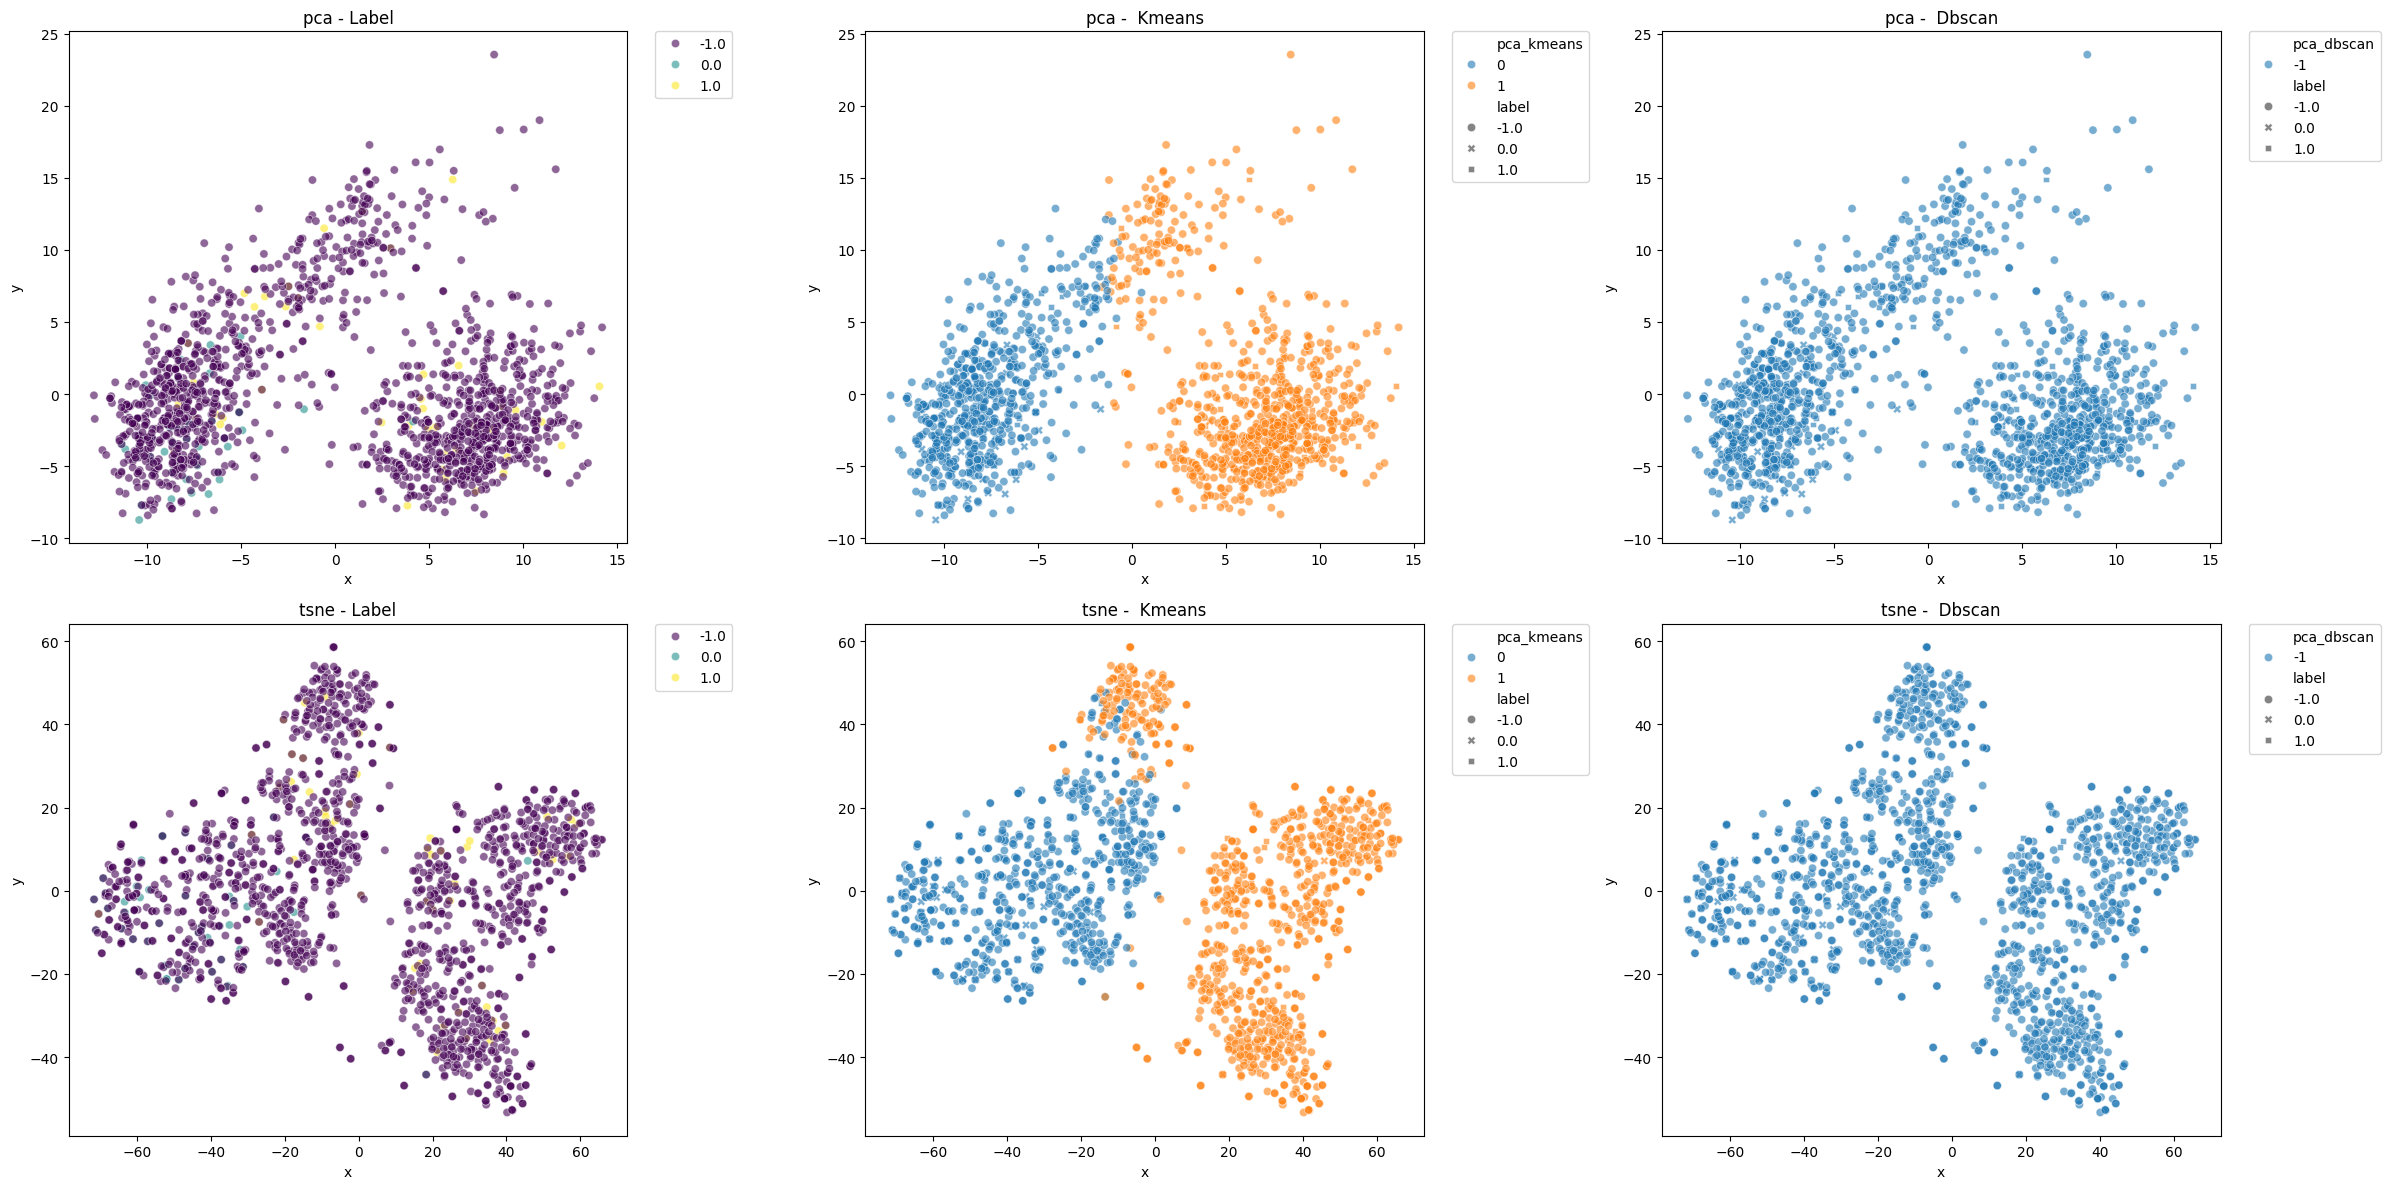

In [20]:
# ======================= SAUVEGARDE ET AFFICHAGE DES RESULTATS ======================
save_datas(
    analyzer.df,
    SAVE_PATH/"unsupervised"/EXPERIMENT_NAME,
    filename="df_cluster",
    format ="parquet"
)

fig_cluster = plot_clustering(analyzer.df, analyzer.reductions,'pca_')
save_figure(
    f"plot_unsupervised_{EXPERIMENT_NAME}",
    SAVE_PATH/"figures"
)#, unsupervised_manager.root_path / "figures")

- Les scores ARI et silhouettes sont faibles avec KMeans et de 0/-1 avec DBSCAN donc les algorithmes de regroupement distinguent peu une image cancereuse d'une image saine (et même pas du tout pour DBSCAN).
- Le clustering n'est pas bon (silhouette très faible), mais il capte un signal médical réel (ARI correct). Et c'est justement pour cela qu'un entrainement semi supervisé est performant: elle va permettre de ne garder que les points au centre des nuages et d'ignorer la zone de chevauchement.

Ce résultat était probable car le ResNet est un CNN pré-entrainé sur ImageNet qui contient plus de 14 millions d'images haute résolution de 224 pixels sur divers catégories (plus de 1000) allant des animmaux, aux vehicules en passant pour des sous-catégories... Cependant il est probable que le cas particulier des radiographies, plus spécifiquement sur le cancer encéphalite est peu présent (voir absent) du jeu couplé à la faible quantité de données, aux qualité d'image variable et autres bruits, il en découle ainsi que ResNet reconnait dans les très grandes lignes (une tête, un humain?) mais est incapable de faire la distinction d'un cerveau sain VS cerveau avec un cancer.

In [21]:
# ================== Nettoyage =================
del (df_features, df_cluster, reduction_dim,
    analyzer, unsupervised_manager,
)
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()